# NIST Repo

# Analysing LPBF cross sectional images

## Find, retreive, and process image data for materials science

This notebook illustrates a technique to analyse cross-section images of melt pools of single track laser powder bed fusion images.

The notebook executes a sample query to the AMBench metadata repository via its API, then retrieves and processes the records.  The script then performs some basic image analysis and plots the results.  

## Step 1: Install and import required packages

First, we need to import packages that we will use to do the processing. Each import statement includes a comment describing what that package does.

The `pycdcs` package is used in this notebook to query the AMBench metadata repository that contains information about the AMBench 2018 data.

**Note:** This compute image should come pre-installed with `pycdcs`. If this image does not, then when you run the  code cell below, you will get an error that says `ModuleNotFoundError: No module named 'cdcs'`.

To fix that error, close this sample notebook. Open a new Terminal in SciServer Compute so you can run a command on the command line. Run the following command:

`pip install git+https://github.com/lmhale99/pycdcs`

Close down the terminal, open this notebook, and run the cell below.

In [ ]:
# Uncomment and run this command here only if you see the error mentioned above
!pip install git+https://github.com/lmhale99/pycdcs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lmhale99/pycdcs to /tmp/pip-req-build-j1uyucog
  Running command git clone --filter=blob:none --quiet https://github.com/lmhale99/pycdcs /tmp/pip-req-build-j1uyucog
  Resolved https://github.com/lmhale99/pycdcs to commit 3aeaeb4782054a220e916c189ffe440d113b571d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.2 MB/s eta 0:00:00
  Created wheel for cdcs: filename=cdcs-0.2.1-py3-none-any.whl size=27209 sha256=cd0f5939097d8d9c77beb55014dd43ef559fb4a85eb068f707d04831bd78a002
  Stored in directory: /tmp/pip-ephem-wheel-cache-tvt_zhts/wheels/82/c6/72/261f4e2412d4aa8005af1b426780408a642282e3234b5d5387
Successfully built cdcs


In [ ]:
# Package to find images in the AMBench repository
## This will allow us to find images to process
## These packages query NIST's Configurable Data Curation System (CDCS):
### https://www.nist.gov/itl/ssd/information-systems-group/configurable-data-curation-system-cdcs
from cdcs import CDCS 
print('Imported!')

Imported!


In [ ]:
# Data processing packages
import pandas as pd
import math
import numpy as np

#image_scale = 0.062   # Image scale in microns per pixel (here, 1 px = 0.062 microns)


# Package to parse metadata from the AMBench repo to find where to download image files
import lxml.etree as et

# Packages to download and save image files
import requests
from urllib import request
import os

# Packages to do image processing once we have the images downloaded
## From the scikit-image package; we only import the parts of the package that we need 
### scikit-image website: https://scikit-image.org/
from skimage import io              # read/write images
from skimage import filters         # apply filters to images
from skimage import segmentation    # divide image into sections
from skimage import morphology      # work with features found in image
from skimage import measure         # measure pixel sizes of features within image
from skimage import data
from skimage import util
from skimage import img_as_float

from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)

import cv2

# Packages to plot results
import matplotlib.pyplot as plt   
import matplotlib.image as mpimg  
import matplotlib.patches as patches


# Set pandas option to show the entire width of each column
pd.set_option('display.max_colwidth', None)

print('Packages imported!')

Packages imported!


## Step 2: Create functions

For some complex operations that we need to do repeatedly, it's easier to move the operations into a function call. This slows down the code slightly, but makes it much easier to read and to follow the logic of the notebook.

The function <code>xml_url_find</code> is defined below. It takes in the XML returned by CDCS and returns the URLs of the images to be used in image analysis.

In [ ]:
# Function to get download links from XML returned by AMBench data repository
# function xml_url_find(xml,searchphrase,mtype):
## Inputs:
### xml: contents of XML file for one of the ambench.nist.gov datasets, in string format
### searchphrase: search phrase contained in the file name (in our case, "BF")
### mtype: filetype (in our case, "image/tiff")

## Returns:
### A four-item list containing:
#### (0) the name of the image file to be downloaded
#### (1) the URL at which to download the image file
#### (2) laser track number for that image
#### (3) case label for that image

def xml_url_find(xml,searchphrase,mtype):
    root=et.fromstring(xml)
    caseid=root.find('.//TraceID')[0].tag[5]
    track=root.find('.//TrackNumber')
    for element in root.iter('downloadURL'):
        u=request.urlopen(element.text)
        if (    # search XML to find searchphrase in filename and mytpe in file type
            (searchphrase in u.info().get_filename()) 
            and (mtype in u.info().get_content_type())
        ):
            name=u.info().get_filename()
            url=element.text
            return [name,url,track.text,caseid]


print('ok')

ok


In [ ]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

def one_channel(img, channel='gray'):
  '''
  Returns a single channel of the image.
  '''
  if channel=='gray':
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  elif channel=='blue':
    return img[:, :, 0]
  elif channel=='green':
    return img[:, :, 1]
  elif channel=='red':
    return img[:, :, 2]
  else:
    print('invalid channel name')

def blur(img, kernel=3, size=(512,512), form='bilateral'):
  '''
  Returns a resized, de-noised, blurred image 
  by either gaussian or bilateral blurring.
  '''
  if size!=None:
    img_resized = cv2.resize(img, dsize=size, interpolation=cv2.INTER_LINEAR)
  else:
    img_resized = img
  
  img_denoised = np.where(img_resized>30, img_resized, 0)

  if form=='bilateral':
    img_blur = cv2.bilateralFilter(img_denoised, kernel, 75, 9)
  elif form=='gaussian':
    img_blur = cv2.GaussianBlur(img_denoised, (kernel,kernel), 0) 
  elif form==None:
    img_blur = img_denoised
  else:
    print('invalid form of blurring')

  return img_blur

def equalise(img, technique='CLAHE'):
  '''
  Returns equalised image by either CLAHE or EqHist technique.
  '''
  if technique=='CLAHE':
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10,10))
    equalised_img = clahe.apply(img)
  elif technique=='EqHist':
    equalised_img = cv2.equalizeHist(img)
  else:
    print('Choose technique as either `CLAHE` or `EqHist`')
    equalised_img = img
  
  return equalised_img

In [ ]:
def edge_detection(img, centre_x, centre_y):
  img_blur = blur(one_channel(img)[:], kernel=31, size=(1500, 1000), form='bilateral')
  edges = cv2.Canny(img_blur,10,40)

  kernel = np.ones((5,5),np.uint8)
  dilation = cv2.dilate(edges,kernel,iterations = 1)

  dilation_blur = blur(dilation, kernel=51, size=(1500, 1000), form='gaussian')

  mask = dilation.copy()
  cv2.floodFill(mask, None, (centre_x,centre_y), 255)
  mask = mask - dilation

  return dilation_blur, mask

def mgas(img, initialisation, iterations=200, smoothing=1, balloon=1.0, threshold=0.95):
  image = img_as_float(img)
  gimage = inverse_gaussian_gradient(image)

  # Initial level set
  init_ls = np.zeros(image.shape, dtype=np.int8)
  for pixel in initialisation:
    init_ls[int(pixel[0]), int(pixel[1])] = 1
  
  # List with intermediate results for plotting the evolution
  evolution = []
  ls = []
  callback = store_evolution_in(evolution)
  ls = morphological_geodesic_active_contour(gimage, iterations=iterations,
                                            init_level_set=init_ls,
                                            smoothing=smoothing, balloon=float(balloon),
                                            threshold=float(threshold),
                                            iter_callback=callback)
  
  return ls, evolution

## Step 3: Find datasets to work with

With setup done, we now begin the main part of the notebook by finding appropriate datasets.

The AMBench data repository includes hundreds of datasets associated with AMBench challenges. Each dataset includes metadata describing its purpose, and the conditions used to generate it. The actual data consists of images stored as .tiff files on a separate server at NIST. The datasets retreived from the data repository contain pointers to the image locations.

This section of the notebook searches the AMBench data repository for a keyword - in this case, "MP" (for "melt pool"). It then downloads the metadata for all public datasets with your selected keyword. You can see information about each returned dataset by running the code block with the `describe_datasets = True`.

In [ ]:
keyword='MP'                # keyword to search data repository for: MP = melt pool
describe_datasets = True    # show name and basic metadata for each dataset
##show_dataset_xml = False     # show full metadata for each dataset (uses function show_xml, defined at the end of this notebook)

print('querying AMBench data repository for keyword {0:}...'.format(keyword))
curator = CDCS('https://ambench.nist.gov/', username='') # query repo (CDCS) anonymously
datasets_df = curator.query(  # search for results, return as a pandas dataframe:
    keyword=keyword,           ## results should match this keyword
    template='AM-Bench-2018'   ## and be associated with this tempalte
    ) 

### convert all date fields to pandas date format
for thiscol in ['creation_date', 'last_modification_date', 'last_change_date']:
    datasets_df.loc[:, thiscol] = pd.to_datetime(datasets_df[thiscol], errors='coerce')
    
### use the dataset ID as the index of the dataframe, then sort by that ID    
datasets_df = datasets_df.set_index('id')

print('Found {0:,.0f} datasets matching keyword {1:}!'.format(len(datasets_df), keyword))
print('------------------------------------------------')

if (describe_datasets):
    for ix, thisrow in datasets_df.iterrows():
        print('\n')
        print('Dataset id = {0:}'.format(ix))
        print('\tTitle: {0:}'.format(thisrow['title']))
        print('\tCreated: {0:}'.format(thisrow['creation_date'].strftime('%Y-%m-%d')))
#         if (show_dataset_xml):
#             show_xml(thisrow['xml_content'])
        
print('------------------------------------------------')
print('Done!')

querying AMBench data repository for keyword MP...
Found 10 datasets matching keyword MP!
------------------------------------------------


Dataset id = 3
	Title: AMB2018-02-AMMT-625-TR8-MP.xml
	Created: 2021-09-02


Dataset id = 35
	Title: AMB2018-02-AMMT-625-TR4-MP.xml
	Created: 2021-09-02


Dataset id = 15
	Title: AMB2018-02-AMMT-625-TR3-MP.xml
	Created: 2021-09-02


Dataset id = 42
	Title: AMB2018-02-AMMT-625-TR1-MP.xml
	Created: 2021-09-02


Dataset id = 2
	Title: AMB2018-02-AMMT-625-TR6-MP.xml
	Created: 2021-09-02


Dataset id = 25
	Title: AMB2018-02-AMMT-625-TR10-MP.xml
	Created: 2021-09-02


Dataset id = 47
	Title: AMB2018-02-AMMT-625-TR2-MP.xml
	Created: 2021-09-02


Dataset id = 49
	Title: AMB2018-02-AMMT-625-TR7-MP.xml
	Created: 2021-09-02


Dataset id = 46
	Title: AMB2018-02-AMMT-625-TR5-MP.xml
	Created: 2021-09-02


Dataset id = 57
	Title: AMB2018-02-AMMT-625-TR9-MP.xml
	Created: 2021-09-02
------------------------------------------------
Done!


## Step 4: Find download links for each dataset

Most of the metadata returned by the AMBench data repository is stored in XML format, easy for computers to store and process but hard for humans to read. One important piece of metadata in each dataset is a field called `downloadURL`, which gives the location where image(s) associated with that dataset can be downloaded.

This notebook includes a helper function called `xml_url_find` (defined in the "Create Functions" section above) that searches through the XML to find the download URL for each image to be processed. For this demo notebook, consider that function as a black box; if you want to learn how it works, see the function documentation in the setup step above. The `xml_url_find` function returns track, case, and image URL for each row in the dataset.



In [ ]:
searchphrase='BF'  # used by function xml_url_find, don't worry about what it means now

datasets_df = datasets_df.assign(   # assign blanks to values to be computed later
    filename = np.nan, url = np.nan, track = np.nan, case = np.nan
) 

### Loop through all datasets and get track/case number and URL to download image
print('Finding URLs for images...')
cnt = 0
for ix, thisrow in datasets_df.iterrows():
    if (np.mod(cnt,5) == 0):
        print('\tFinding URL {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(datasets_df)))
    datasets_df.loc[ix, 
                    ['filename', 'url', 'track', 'case']
                   ] = xml_url_find(thisrow['xml_content'],'BF','image/tiff') # giving xml_url_find each xml string and searching for
    cnt += 1


# set track to numeric, then sort by track
datasets_df.loc[:, 'track'] = pd.to_numeric(
    datasets_df['track'], downcast='integer', errors='coerce'
)
datasets_df = datasets_df.sort_values(by='track') 

# assign blanks for values to compute later
datasets_df = datasets_df.assign(melt_pool_width_pixels = np.nan)
datasets_df = datasets_df.assign(melt_pool_depth_pixels = np.nan)
datasets_df = datasets_df.assign(melt_pool_width_microns = np.nan)
datasets_df = datasets_df.assign(melt_pool_depth_microns = np.nan)

print('\n')
print('Found download links for {0:,.0f} images!'.format(len(datasets_df['url'].dropna())))

datasets_df[['track', 'case', 'url', 'filename', 'melt_pool_width_pixels', 'melt_pool_depth_pixels', 'melt_pool_width_microns', 'melt_pool_depth_microns']]

Finding URLs for images...
	Finding URL 1 of 10...
	Finding URL 6 of 10...


Found download links for 10 images!


,track,case,url,filename,melt_pool_width_pixels,melt_pool_depth_pixels,melt_pool_width_microns,melt_pool_depth_microns
id,,,,,,,,
42,1,C,https://ambench.nist.gov/rest/blob/download/384,AMB18-02-AMMT-Trace01-50xBF-ZStk-EDF.tif,NaN,NaN,NaN,NaN
47,2,C,https://ambench.nist.gov/rest/blob/download/424,AMB18-02-AMMT-Trace02-50xBF-ZStk-EDF.tif,NaN,NaN,NaN,NaN
15,3,C,https://ambench.nist.gov/rest/blob/download/138,AMB18-02-AMMT-Trace03-50xBF-ZStk-EDF.tif,NaN,NaN,NaN,NaN
35,4,C,https://ambench.nist.gov/rest/blob/download/319,AMB18-02-AMMT-Trace04-50xBF-ZStk-EDF.tif,NaN,NaN,NaN,NaN
46,5,A,https://ambench.nist.gov/rest/blob/download/415,AMB18-02-AMMT-Trace05-50xBF-ZStk-EDF.tif,NaN,NaN,NaN,NaN
2,6,A,https://ambench.nist.gov/rest/blob/download/30,AMB18-02-AMMT-Trace06-50xBF-ZStk-EDF.tif,NaN,NaN,NaN,NaN
49,7,A,https://ambench.nist.gov/rest/blob/download/461,AMB18-02-AMMT-Trace07-50xBF-ZStk-EDF.tif,NaN,NaN,NaN,NaN
3,8,B,https://ambench.nist.gov/rest/blob/download/39,AMB18-02-AMMT-Trace08-50xBF-ZStk-EDF.tif,NaN,NaN,NaN,NaN
57,9,B,https://ambench.nist.gov/rest/blob/download/535,AMB18-02-AMMT-Trace09-50xBF-ZStk-EDF.tif,NaN,NaN,NaN,NaN


## Step 5: Display all images and select one

In this section, all the images from the dataset above are downloaded and displayed. The image ID of the image to be analysed must be entered in the next section

In [ ]:
datasets_df.shape[0]

10

42
(2832, 4248, 3)
47
(2832, 4248, 3)
15
(2832, 4248, 3)
35
(2832, 4248, 3)
46
(2832, 4248, 3)
2
(2832, 4248, 3)
49
(2832, 4248, 3)
3
(2832, 4248, 3)
57
(2832, 4248, 3)
25
(2832, 4248, 3)


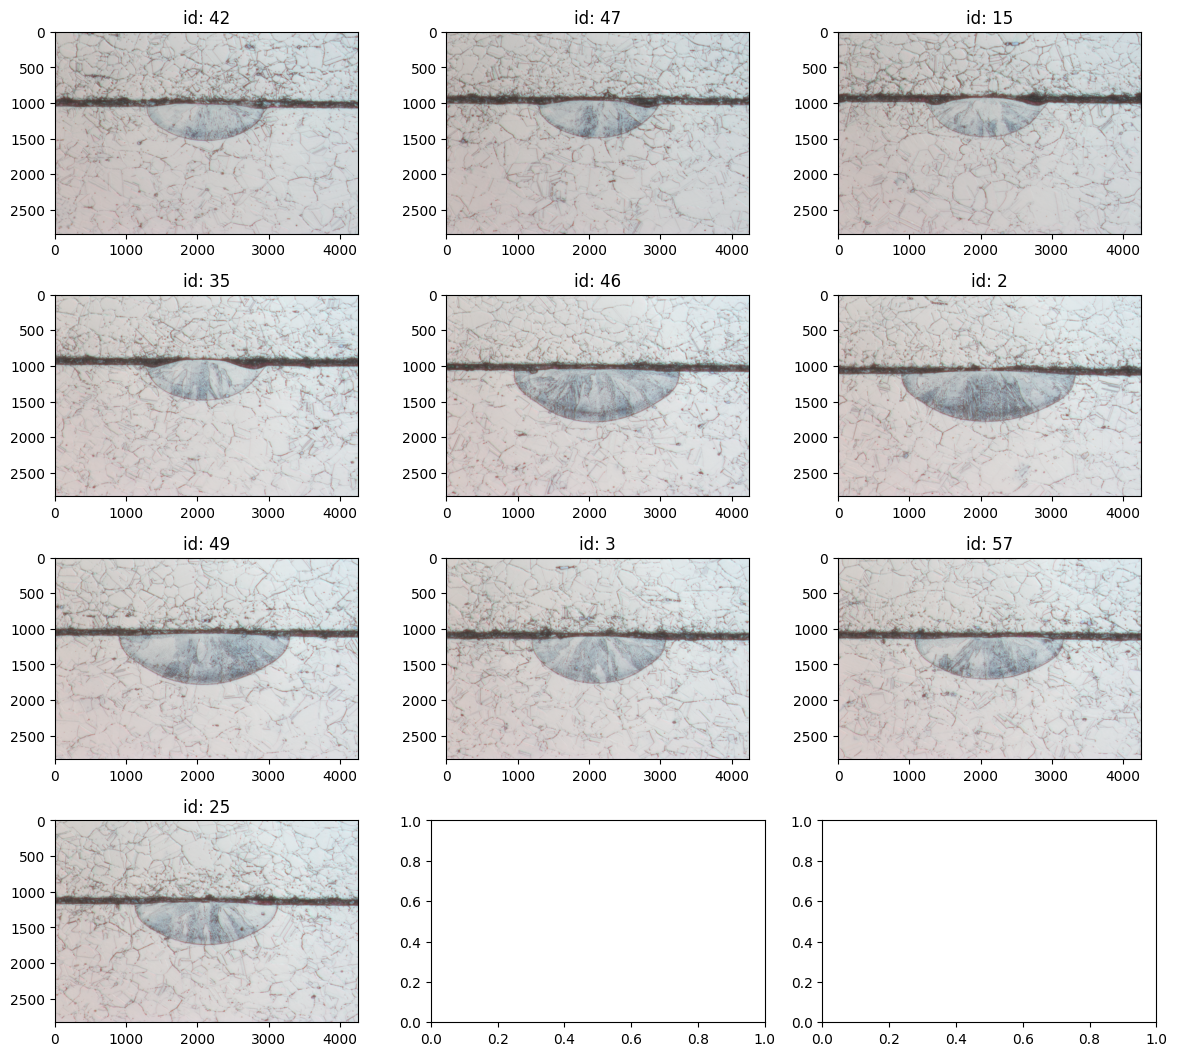

In [ ]:
cnt = 0

columns = 3 # you can change this based on what feels most comfortable for your viewing
numberOfImages = datasets_df.shape[0]
fig, axes = plt.subplots(numberOfImages//columns+1, columns, figsize=(12, 8*(numberOfImages//columns+1)/columns), sharex=False, sharey=False)
ax = axes.ravel()
for ix, thisrow in datasets_df.iterrows():
  print(ix)

  req = request.urlopen(thisrow['url'])
  arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
  img = cv2.imdecode(arr, -1) # 'Load it as it is'
  print(img.shape)

  ax[cnt].imshow(img)
  ax[cnt].title.set_text('id: '+str(ix))
  cnt += 1

plt.tight_layout()

# Step 6: Download and process images

The code cell below takes a few minutes to run.

<ipython-input-11-3968d5cb0cf5>:51: FutureWarning: `iterations` is a deprecated argument name for `morphological_geodesic_active_contour`. It will be removed in version 1.0. Please use `num_iter` instead.
  output = morphological_geodesic_active_contour(gimage, iterations=200,


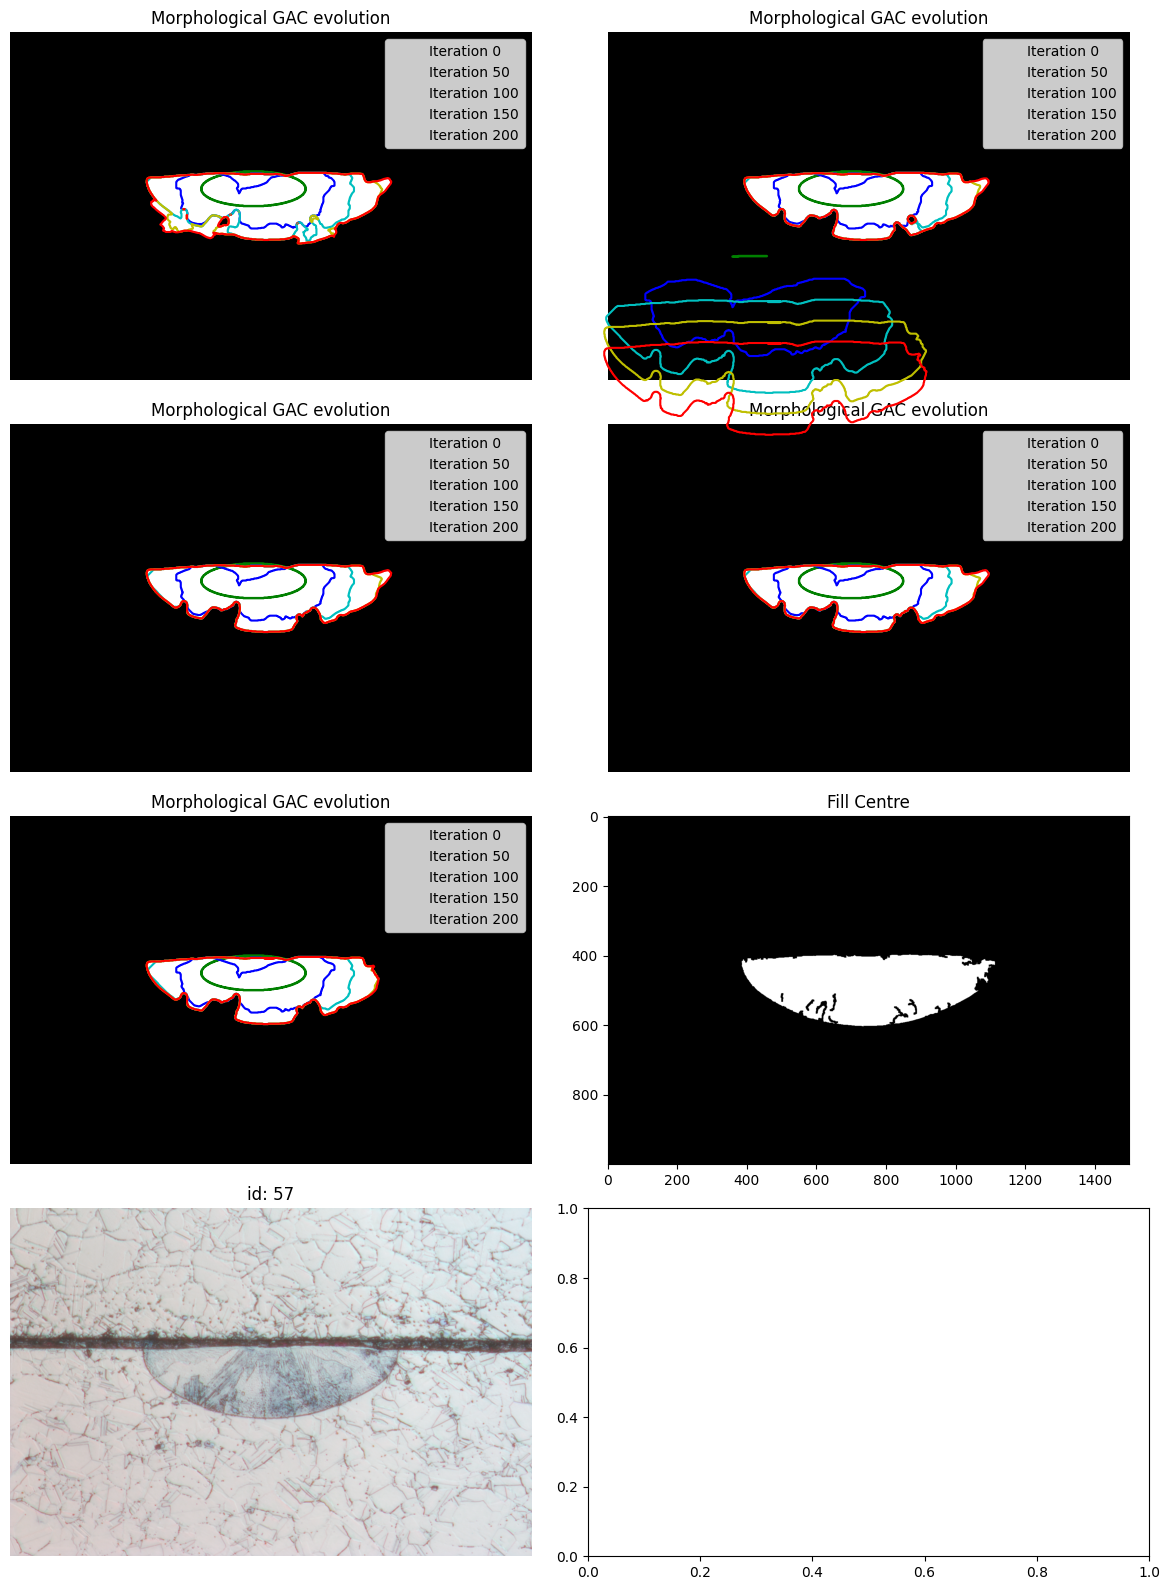

In [ ]:
id_to_analyse = 57

df_hyperparams = pd.DataFrame(np.array([[1.2, 0.85], 
                                        [1.2, 0.95], 
                                        [1.2, 1.05], 
                                        [1.0, 0.85], 
                                        [1.0, 0.95], 
                                        ['fill', np.nan]]))
df_hyperparams.columns = ['balloon', 'threshold']

req = request.urlopen(datasets_df.loc[id_to_analyse, 'url'])
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'

centre_x = 700
centre_y = 450

s = np.linspace(0, 2*np.pi, 3200)
r = centre_y + 50*np.sin(s)
c = centre_x + 150*np.cos(s)
init = np.array([r, c]).T

fig, axes = plt.subplots(4, 2, figsize=(12, 16))
ax = axes.flatten()

dilation_blur, mask = edge_detection(img, centre_x, centre_y)

ax[6].imshow(img)
ax[6].set_title('id: '+str(id_to_analyse), fontsize=12)
ax[6].set_axis_off()

for index, row in df_hyperparams.iterrows():
  if row['balloon']=='fill':
    output = mask
    ax[index].imshow(output, cmap='gray')
    ax[index].set_title('Fill Centre')
  else:
    # output, evolution = mgas(img=dilation_blur, initialisation=init, balloon=row['balloon'], threshold=row['threshold'])
    image = img_as_float(dilation_blur)
    gimage = inverse_gaussian_gradient(image)

    # Initial level set
    init_ls = np.zeros(image.shape, dtype=np.int8)
    for pixel in init:
      init_ls[int(pixel[0]), int(pixel[1])] = 1
    
    # List with intermediate results for plotting the evolution
    evolution = []
    # ls = []
    callback = store_evolution_in(evolution)
    output = morphological_geodesic_active_contour(gimage, iterations=200,
                                              init_level_set=init_ls,
                                              smoothing=1, balloon=float(row['balloon']),
                                              threshold=float(row['threshold']),
                                              iter_callback=callback)
    output = output*255
  
    ax[index].imshow(output, cmap="gray")
    ax[index].set_axis_off()
    contour = ax[index].contour(evolution[0], [0.5], colors='g')
    contour.collections[0].set_label("Iteration 0")
    contour = ax[index].contour(evolution[50], [0.5], colors='b')
    contour.collections[0].set_label("Iteration 50")
    contour = ax[index].contour(evolution[100], [0.5], colors='c')
    contour.collections[0].set_label("Iteration 100")
    contour = ax[index].contour(evolution[150], [0.5], colors='y')
    contour.collections[0].set_label("Iteration 150")
    contour = ax[index].contour(evolution[200], [0.5], colors='r')
    contour.collections[0].set_label("Iteration 200")
    ax[index].legend(loc="upper right")
    title = "Morphological GAC evolution"
    ax[index].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()